In [21]:
from __future__ import print_function
from __future__ import absolute_import

import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from imm.models.imm_model import IMMModel
from imm.eval.eval_imm import load_configs
from imm.utils.plot_landmarks import plot_landmarks

In [22]:
# configuration
image_size = [128, 128] # h, w
paths_config = os.path.join('..', 'configs', 'paths', 'default.yaml')
experiment_name = 'video-10pts'
images_dir =  os.path.join('resources', 'visualize')

config = load_configs(
    [paths_config,
     os.path.join('..', 'configs', 'experiments', experiment_name + '.yaml')])

checkpoint_name = 'model.ckpt-98000'
checkpoint_file = os.path.join('..', 'experiments', 'logs', experiment_name, checkpoint_name)

In [23]:
# load images
image_files = os.listdir(images_dir)
images = []
for image_file in image_files:
    image = Image.open(os.path.join(images_dir, image_file))
    image = np.array(image.resize(image_size[::-1]), dtype=np.float32)
    images.append(image)
images = np.array(images)

In [25]:
with tf.Graph().as_default() as graph:
    # set up dataset
    dataset = tf.data.Dataset.from_tensors({'image': images, 'future_image': images})
    iterator = dataset.make_one_shot_iterator()
    inputs = iterator.get_next()
    
    # set up model
    training_pl = False
    net_instance = IMMModel(config.model)
    _, _, _, tensors = net_instance.build(
        inputs, training_pl=training_pl, output_tensors=True, build_loss=False)
    
    print(tensors)
    
    # start a new session
    session_config = tf.ConfigProto(allow_soft_placement=True,
                                    log_device_placement=False)
    session_config.gpu_options.allow_growth = True
    with tf.Session(config=session_config) as session:
        global_init = tf.global_variables_initializer()
        local_init = tf.local_variables_initializer()
        session.run([global_init, local_init])

        # restore checkpoint
        if tf.gfile.Exists(checkpoint_file) or tf.gfile.Exists(checkpoint_file + '.index'):
            reader = tf.train.NewCheckpointReader(checkpoint_file)
            vars_to_restore = tf.global_variables()
            checkpoint_vars = reader.get_variable_to_shape_map().keys()
            vars_ignored = [
                v.name for v in vars_to_restore if v.name[:-2] not in checkpoint_vars]
            if vars_ignored:
                print('vars-IGNORED (not restoring)')
                print(', '.join(vars_ignored))
            vars_to_restore = [
                v for v in vars_to_restore if v.name[:-2] in checkpoint_vars]
            restorer = tf.train.Saver(var_list=vars_to_restore)
            restorer.restore(session, checkpoint_file)
        else:
            raise Exception('model file does not exist at: ' + checkpoint_file)

        # evaluate model
        landmarks = session.run(tensors['gauss_yx'])    

{'future_image': <tf.Tensor 'IteratorGetNext:0' shape=(8, 128, 128, 3) dtype=float32>, 'im': <tf.Tensor 'IteratorGetNext:1' shape=(8, 128, 128, 3) dtype=float32>, 'gauss_yx': <tf.Tensor 'model/pose_encoder/stack:0' shape=(8, 10, 2) dtype=float32>, 'image': <tf.Tensor 'IteratorGetNext:1' shape=(8, 128, 128, 3) dtype=float32>, 'future_im': <tf.Tensor 'IteratorGetNext:0' shape=(8, 128, 128, 3) dtype=float32>, 'future_im_pred': <tf.Tensor 'model/split:0' shape=(8, 128, 128, 3) dtype=float32>, 'pose_embedding': <tf.Tensor 'Max:0' shape=(8, 128, 128, 3) dtype=float32>}
vars-IGNORED (not restoring)
model/renderer/conv_6/batch_normalization/gamma:0, model/renderer/conv_6/batch_normalization/beta:0, model/renderer/conv_6/batch_normalization/moving_mean:0, model/renderer/conv_6/batch_normalization/moving_variance:0, model/renderer/conv_7/conv_7/w:0, model/renderer/conv_7/conv_7/b:0, model/renderer/conv_7/batch_normalization/gamma:0, model/renderer/conv_7/batch_normalization/beta:0, model/rendere

InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [3,3,64,64] rhs shape= [3,3,64,9]
	 [[Node: save/Assign_129 = Assign[T=DT_FLOAT, _class=["loc:@model/renderer/conv_6/conv_6/w"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](model/renderer/conv_6/conv_6/w, save/RestoreV2:129)]]
	 [[Node: save/RestoreV2/_101 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_154_save/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op u'save/Assign_129', defined at:
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-e406fbc89c8d>", line 36, in <module>
    restorer = tf.train.Saver(var_list=vars_to_restore)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1281, in __init__
    self.build()
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1293, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1330, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 778, in _build_internal
    restore_sequentially, reshape)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 112, in restore
    self.op.get_shape().is_fully_defined())
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/ops/state_ops.py", line 216, in assign
    validate_shape=validate_shape)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/ben/anaconda2/envs/imm/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [3,3,64,64] rhs shape= [3,3,64,9]
	 [[Node: save/Assign_129 = Assign[T=DT_FLOAT, _class=["loc:@model/renderer/conv_6/conv_6/w"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](model/renderer/conv_6/conv_6/w, save/RestoreV2:129)]]
	 [[Node: save/RestoreV2/_101 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_154_save/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [19]:
# denormalize landmarks
landmarks = ((landmarks + 1) / 2.0) * np.array(image_size)

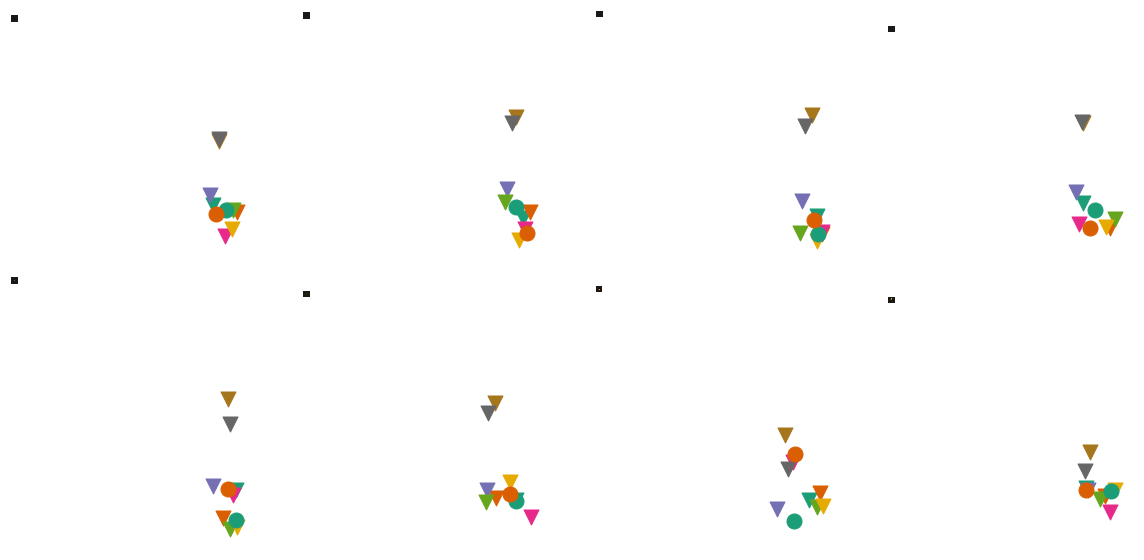

In [20]:
# plot unsupervised landmarks
cols = min(4, len(images))
rows = int(np.ceil(len(images) / float(cols)))
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
for i, ax in enumerate(np.ravel(axs)):
    if i < len(images):
        ax.imshow(images[i].astype(np.uint8))
        plot_landmarks(ax, landmarks[i], size=2.5)
    plt.tight_layout()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()
plt.savefig(os.path.join('resources', 'figures', 'landmarks.png'))

<Figure size 432x288 with 0 Axes>